<a href="https://colab.research.google.com/github/balu337/TicketClassification/blob/main/Feb25_Murali_Automatic_Ticket_Classification_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Problem Statement

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [53]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
from nltk.tokenize import word_tokenize
from nltk import pos_tag
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [54]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
# Opening JSON file
file_path = '/content/drive/MyDrive/Keras/tProject/complaints-2021-05-14_08_16.json'
#'/content/drive/My Drive/complaints-2021-05-14_08_16.json'
#path = '/content/drive/MyDrive/Keras/tProject/complaints-2021-05-14_08_16.json'

# Read JSON file
with open(file_path, 'r') as f:
    data = json.load(f)

In [56]:
# normalize the json data to dataframe
df=pd.json_normalize(data)

In [57]:
df.shape

(78313, 22)

## Data preparation

In [58]:
# Inspect the dataframe to understand the given data.
df.head()


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [59]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [60]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78313 entries, 0 to 78312
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   _index                             78313 non-null  object 
 1   _type                              78313 non-null  object 
 2   _id                                78313 non-null  object 
 3   _score                             78313 non-null  float64
 4   _source.tags                       10900 non-null  object 
 5   _source.zip_code                   71556 non-null  object 
 6   _source.complaint_id               78313 non-null  object 
 7   _source.issue                      78313 non-null  object 
 8   _source.date_received              78313 non-null  object 
 9   _source.state                      76322 non-null  object 
 10  _source.consumer_disputed          78313 non-null  object 
 11  _source.product                    78313 non-null  obj

In [61]:
# Assign new column names
df.columns = ['index', 'type', 'id', 'score','tags','zip_code','complaint_id','issue','date_received','state','consumer_disputed','product','company_response','company','submit_via','sent_date','public_res','sub_product','timely','complaint','sub_issue','consent']

In [62]:
df.columns

Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submit_via', 'sent_date', 'public_res',
       'sub_product', 'timely', 'complaint', 'sub_issue', 'consent'],
      dtype='object')

In [63]:
#Assign nan in place of blanks in the complaints column
df['complaint'] = df['complaint'].replace(r'^\s*$', np.nan, regex=True)

In [64]:
df['complaint']

,complaint
0,NaN
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
3,NaN
4,NaN
...,...
78308,NaN
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,I am not familiar with XXXX pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...


In [65]:
print(df['complaint'].isna().sum())

57241


In [66]:
#Remove all rows where complaints column is nan
df_cleaned = df.dropna(subset=['complaint'])

In [67]:
df_cleaned.count()

,0
index,21072
type,21072
id,21072
score,21072
tags,3816
zip_code,16427
complaint_id,21072
issue,21072
date_received,21072
state,20929


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [68]:
df_clean = pd.DataFrame({'complaints': df_cleaned['complaint']})
df_clean

,complaints
1,Good morning my name is XXXX XXXX and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...
10,Chase Card was reported on XX/XX/2019. However...
11,"On XX/XX/2018, while trying to book a XXXX XX..."
14,my grand son give me check for {$1600.00} i de...
...,...
78303,After being a Chase Card customer for well ove...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX..."
78310,I am not familiar with XXXX pay and did not un...
78311,I have had flawless credit for 30 yrs. I've ha...


In [69]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
import re

# Download necessary NLTK resources (only once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger_eng')
# Initialize Lemmatizer
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [70]:
nltk.download('punkt_tab')
# Function to clean text
def clean_text(text):
    if not isinstance(text, str):  # Handle NaN or non-string values
        return ""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\b\w*\d\w*\b', '', text)  # Remove words containing numbers
    return text.strip()  # Remove extra spaces

# Function to lemmatize text and return a string
def lemmatize_text(text):
    if not isinstance(text, str):
        return ""  # Return empty string for NaN values
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])  # Ensure it returns a string

#Write your function to extract the POS tags
# Functiofn to extract only nouns (NN)
def extract_nouns(text):
    if not isinstance(text, str) or text.strip() == "":
        return ""  # Handle empty or NaN values
    tokens = word_tokenize(text)  # Tokenize text
    pos_tags = pos_tag(tokens)    # Get POS tags
    nouns = [word for word, tag in pos_tags if tag == "NN"]  # Keep only nouns
    return ' '.join(nouns)  # Return cleaned noun-only text

# Apply transformations
df_clean["lemmatized_complaints"] = df_clean["complaints"].apply(lambda x: lemmatize_text(clean_text(x)))
df_clean["complaint_POS_removed"] = df_clean["lemmatized_complaints"].apply(extract_nouns)

# Print the updated DataFrame
print(df_clean)


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                              complaints  \
1      Good morning my name is XXXX XXXX and I apprec...   
2      I upgraded my XXXX XXXX card in XX/XX/2018 and...   
10     Chase Card was reported on XX/XX/2019. However...   
11     On XX/XX/2018, while trying to book a XXXX  XX...   
14     my grand son give me check for {$1600.00} i de...   
...                                                  ...   
78303  After being a Chase Card customer for well ove...   
78309  On Wednesday, XX/XX/XXXX I called Chas, my XXX...   
78310  I am not familiar with XXXX pay and did not un...   
78311  I have had flawless credit for 30 yrs. I've ha...   
78312  Roughly 10+ years ago I closed out my accounts...   

                                   lemmatized_complaints  \
1      good morning my name is xxxx xxxx and i apprec...   
2      i upgraded my xxxx xxxx card in and wa told by...   
10     chase card wa reported on however fraudulent a...   
11     on while trying to book a xxxx x

In [71]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean


,complaints,lemmatized_complaints,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...


In [72]:
df_clean_safe=df_clean

df_clean_safe.shape

(21072, 3)

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




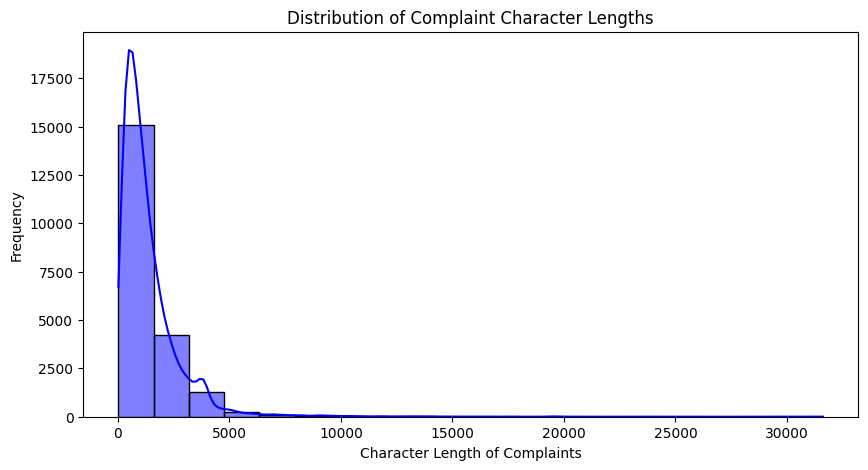

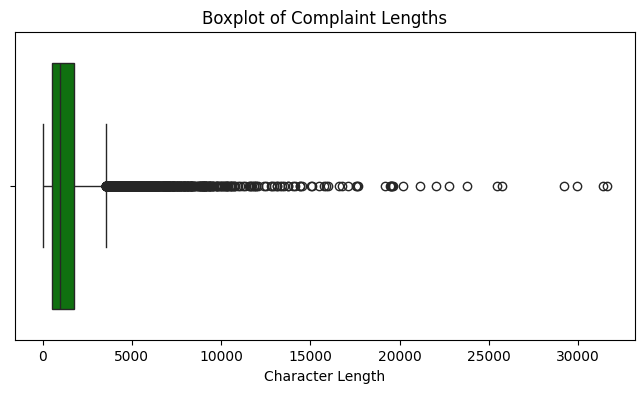

In [73]:
# Write your code here to visualise the data according to the 'Complaint' character length

import matplotlib.pyplot as plt
import seaborn as sns

# Ensure complaints are strings, then calculate their length
df_clean["complaint_length"] = df_clean["complaints"].astype(str).apply(len)

# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(df_clean["complaint_length"], bins=20, kde=True, color="blue")
plt.xlabel("Character Length of Complaints")
plt.ylabel("Frequency")
plt.title("Distribution of Complaint Character Lengths")
plt.show()

# Optional: Boxplot to detect outliers
plt.figure(figsize=(8, 4))
sns.boxplot(x=df_clean["complaint_length"], color="green")
plt.xlabel("Character Length")
plt.title("Boxplot of Complaint Lengths")
plt.show()


In [74]:
df_clean.shape

(21072, 4)

#### Find the top 40 words by frequency among all the articles after processing the text.

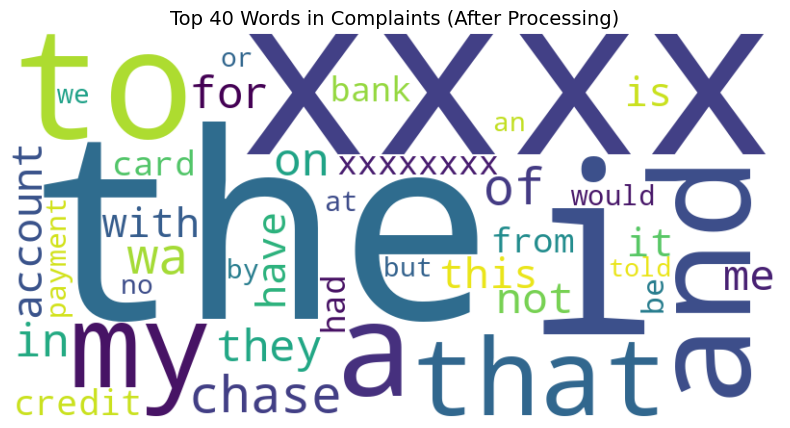

In [75]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text
from wordcloud import WordCloud
from collections import Counter

# Combine all text from the lemmatized complaints
all_text = ' '.join(df_clean["lemmatized_complaints"].dropna())  # Drop NaN values before joining

# Tokenize and count word frequencies
word_freq = Counter(all_text.split())

# Generate WordCloud
wordcloud = WordCloud(width=800, height=400, max_words=40, background_color="white").generate_from_frequencies(word_freq)

# Plot WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")  # Hide axes
plt.title("Top 40 Words in Complaints (After Processing)", fontsize=14)
plt.show()


In [76]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '', regex=True)

In [77]:
df_clean.shape

(21072, 5)

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

<ipython-input-78-5af1cf9d3bc5>:17: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




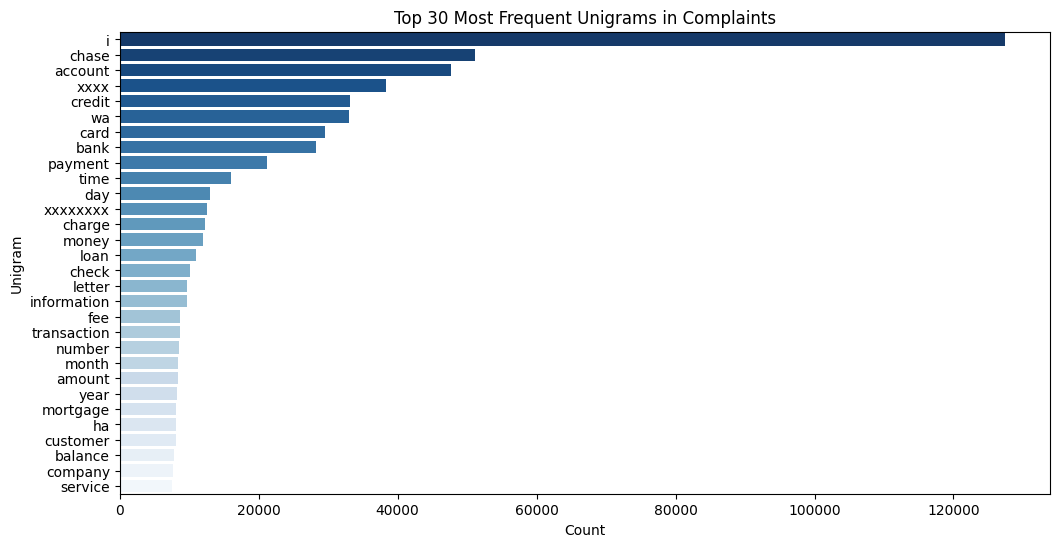

In [78]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).

# Tokenize words from the cleaned complaints column
all_words = ' '.join(df_clean["Complaint_clean"].dropna()).split()  # Drop NaN & split into words

# Count word frequencies
word_freq = Counter(all_words)

# Get the top 30 most common words
top_30_words = word_freq.most_common(30)

# Convert to DataFrame for visualization
df_top_words = pd.DataFrame(top_30_words, columns=['Word', 'Frequency'])

# Plot the top 30 unigrams
plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Word", data=df_top_words, palette="Blues_r")
plt.xlabel("Count")
plt.ylabel("Unigram")
plt.title("Top 30 Most Frequent Unigrams in Complaints")
plt.show()


In [79]:
#Print the top 10 words in the unigram frequency
# Get the top 10 most common words
top_10_words = word_freq.most_common(10)

# Print the top 10 words with their counts
print("Top 10 Unigrams by Frequency:")
for word, freq in top_10_words:
    print(f"{word}: {freq}")

Top 10 Unigrams by Frequency:
i: 127466
chase: 51079
account: 47645
xxxx: 38368
credit: 33094
wa: 32996
card: 29587
bank: 28233
payment: 21167
time: 16038


In [80]:
df_clean.shape

(21072, 5)

<ipython-input-81-1d0bd4746c7a>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




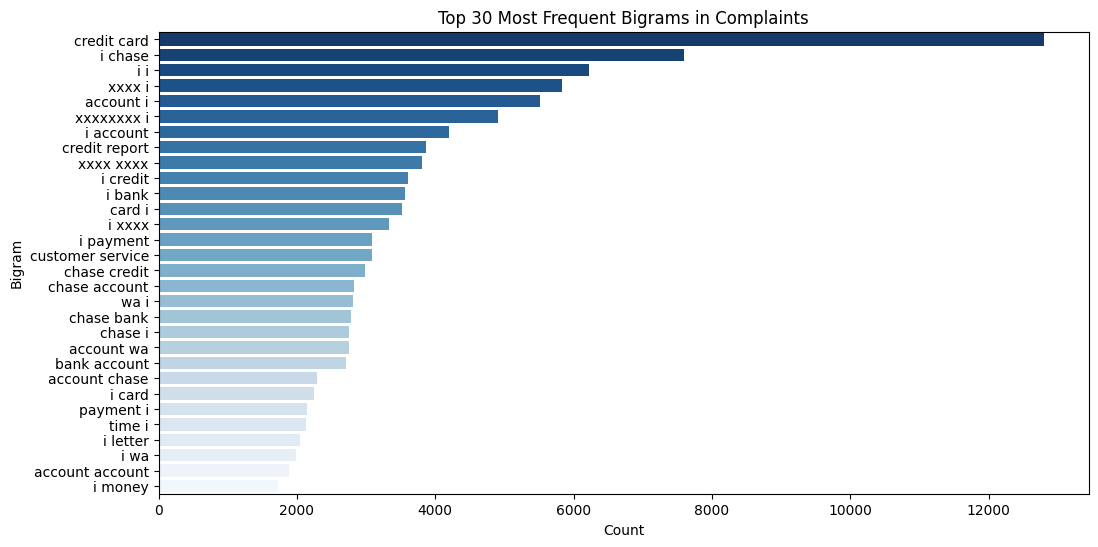

In [81]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).

# Function to extract bigrams from text
def get_bigrams(text):
    words = nltk.word_tokenize(text)  # Tokenize words
    bigrams = list(nltk.bigrams(words))  # Create bigrams
    return bigrams

# Apply bigram extraction on all complaints
all_bigrams = []
df_clean["Complaint_clean"].dropna().apply(lambda text: all_bigrams.extend(get_bigrams(text)))

# Count bigram frequencies
bigram_freq = Counter(all_bigrams)

# Get the top 30 most common bigrams
top_30_bigrams = bigram_freq.most_common(30)

# Convert to DataFrame for visualization
df_top_bigrams = pd.DataFrame(top_30_bigrams, columns=['Bigram', 'Frequency'])
df_top_bigrams['Bigram'] = df_top_bigrams['Bigram'].apply(lambda x: ' '.join(x))  # Convert tuple to string

# Plot the top 30 bigrams
plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Bigram", data=df_top_bigrams, palette="Blues_r")
plt.xlabel("Count")
plt.ylabel("Bigram")
plt.title("Top 30 Most Frequent Bigrams in Complaints")
plt.show()


In [82]:
#Print the top 10 words in the bigram frequency
top_10_bigrams = bigram_freq.most_common(10)

# Print the top 10 bigrams with their counts
print("Top 10 Bigrams by Frequency:")
for bigram, freq in top_10_bigrams:
    print(f"{' '.join(bigram)}: {freq}")

Top 10 Bigrams by Frequency:
credit card: 12803
i chase: 7600
i i: 6216
xxxx i: 5835
account i: 5520
xxxxxxxx i: 4903
i account: 4192
credit report: 3871
xxxx xxxx: 3813
i credit: 3603


In [83]:

df_clean.shape

(21072, 5)

<ipython-input-84-0d9b676c76be>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




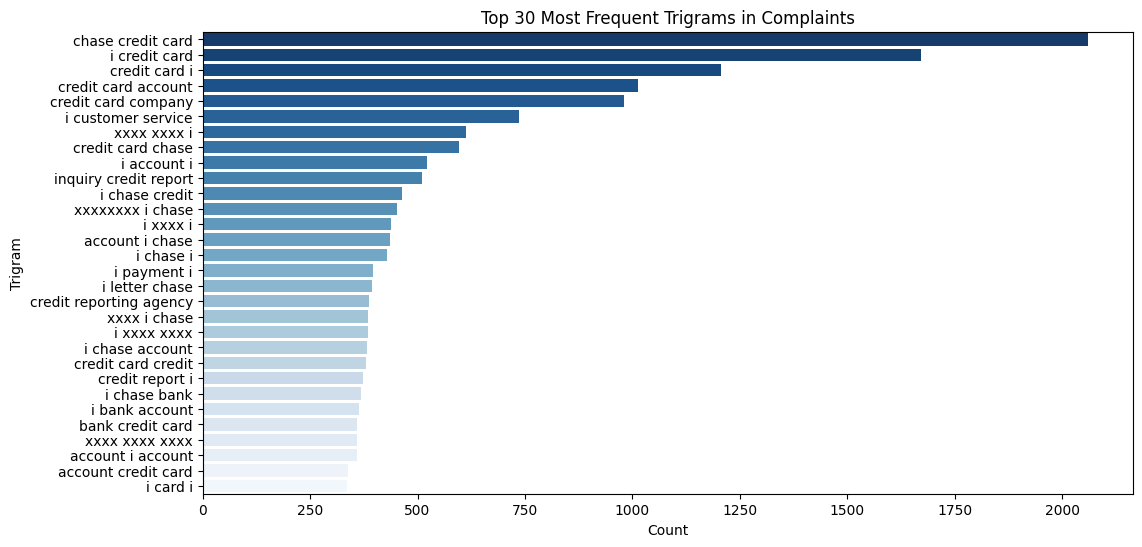

In [84]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).

# Function to extract trigrams from text
def get_trigrams(text):
    words = nltk.word_tokenize(text)  # Tokenize words
    trigrams = list(nltk.trigrams(words))  # Create trigrams
    return trigrams

# Apply trigram extraction on all complaints
all_trigrams = []
df_clean["Complaint_clean"].dropna().apply(lambda text: all_trigrams.extend(get_trigrams(text)))

# Count trigram frequencies
trigram_freq = Counter(all_trigrams)

# Get the top 30 most common trigrams
top_30_trigrams = trigram_freq.most_common(30)

# Convert to DataFrame for visualization
df_top_trigrams = pd.DataFrame(top_30_trigrams, columns=['Trigram', 'Frequency'])
df_top_trigrams['Trigram'] = df_top_trigrams['Trigram'].apply(lambda x: ' '.join(x))  # Convert tuple to string

# Plot the top 30 trigrams
plt.figure(figsize=(12, 6))
sns.barplot(x="Frequency", y="Trigram", data=df_top_trigrams, palette="Blues_r")
plt.xlabel("Count")
plt.ylabel("Trigram")
plt.title("Top 30 Most Frequent Trigrams in Complaints")
plt.show()

In [85]:
#Print the top 10 words in the trigram frequency
top_10_trigrams = trigram_freq.most_common(10)

# Print the top 10 trigrams with their counts
print("Top 10 Trigrams by Frequency:")
for trigram, freq in top_10_trigrams:
    print(f"{' '.join(trigram)}: {freq}")

Top 10 Trigrams by Frequency:
chase credit card: 2061
i credit card: 1671
credit card i: 1205
credit card account: 1014
credit card company: 980
i customer service: 736
xxxx xxxx i: 612
credit card chase: 596
i account i: 522
inquiry credit report: 510


In [86]:
df_clean_safe=df_clean.copy()

df_clean_safe.shape

(21072, 5)

In [87]:
df_clean.shape

(21072, 5)

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [88]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [89]:
#All masked texts has been removed
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,i card agent upgrade date agent wa information...
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,card wa application identity consent service c...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,book ticket i offer ticket card i information...
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,679,chase card customer decade wa solicitation cre...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,2114,i chas visa credit card provider claim purcha...
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2319,i pay risk consumer i bank app chase year mobi...
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,2171,i credit credit card chase freedom problem ba...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [90]:
#Write your code here to initialise the TfidfVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TfidfVectorizer with max_df and min_df
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [91]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
# Create the Document-Term Matrix
dtm = tfidf_vectorizer.fit_transform(df_clean["Complaint_clean"].dropna())

# Get feature names (words in vocabulary)
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"feature_names: {feature_names}")
# Print matrix shape
print(f"TF-IDF Matrix Shape: {dtm.shape}")  # (num_complaints, num_unique_terms)

feature_names: ['__' '___' '____' ... 'zipcode' 'zombie' 'zone']
TF-IDF Matrix Shape: (21072, 6966)


## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints
* Correct the labels if needed
* Map the clusters to topics/cluster names

In [92]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [93]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40)#write your code here

In [94]:
nmf_model.fit(dtm)
len(tfidf_vectorizer.get_feature_names_out())

/usr/local/lib/python3.11/dist-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning:

Maximum number of iterations 200 reached. Increase it to improve convergence.



6966

In [95]:
#Print the Top15 words for each of the topics
# Get feature names (words in vocabulary)
words = tfidf_vectorizer.get_feature_names_out()

# Print the top 15 words for each topic
for topic_idx, topic in enumerate(nmf_model.components_):
    top_words = [words[i] for i in topic.argsort()[-15:]]  # Get top 15 words
    print(f"\nTopic {topic_idx + 1}:")
    print(" ".join(top_words))



Topic 1:
claim checking business number transaction day branch deposit wa fund chase money check bank account

Topic 2:
company claim time fee service merchant fraud purchase transaction dispute wa credit chase charge card

Topic 3:
error year account chase credit auto date time day wa statement month fee balance payment

Topic 4:
identity chase application limit information reporting debt company bureau score account card inquiry report credit

Topic 5:
house bank foreclosure document time rate letter wa year property modification home chase mortgage loan


In [96]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4

# Transform the TF-IDF matrix using the trained NMF model
topic_matrix = nmf_model.transform(dtm)


In [97]:

df_clean_safe.shape

(21072, 5)

In [98]:
df_clean.shape

(21072, 5)

In [99]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_matrix.argmax(axis=1) #write your code to assign topics to each rows.

In [100]:
df_clean.shape

(21072, 6)

In [101]:
df_clean[["Complaint_clean", "Topic"]].head(10)

,Complaint_clean,Topic
1,morning name stop bank cardmember service debt...,0
2,i card agent upgrade date agent wa information...,1
10,card wa application identity consent service c...,3
11,book ticket i offer ticket card i information...,3
14,son deposit chase account fund chase bank acco...,0
15,inquiry,3
17,jp chase account debit card tuesday thursday b...,0
20,summer month i income employment month payment...,2
21,i payment retailer pay chase website i scam ...,1
23,chase credit card credit report company issue,3


In [102]:
df_clean.shape

(21072, 6)

#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [103]:
#Create the dictionary of Topic names and Topics

# Define final topic names after evaluation
Topic_names = {
    0: "Bank Account Services",
    1: "Credit Card or Prepaid Card",
    2: "Mortgage/Loan",
    3: "Theft/Dispute Reporting",
    4: "Others"
}

# Map topic numbers to meaningful names
#df_clean["Topic"] = df_clean["Topic"].map(Topic_names)
df_clean["TopicLable"] = df_clean["Topic"].map(Topic_names)

# Display the first few rows
df_clean[["Complaint_clean", "Topic"]].head()


,Complaint_clean,Topic
1,morning name stop bank cardmember service debt...,0
2,i card agent upgrade date agent wa information...,1
10,card wa application identity consent service c...,3
11,book ticket i offer ticket card i information...,3
14,son deposit chase account fund chase bank acco...,0


In [104]:
df_clean

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic,TopicLable
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,0,Bank Account Services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,i card agent upgrade date agent wa information...,1,Credit Card or Prepaid Card
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,card wa application identity consent service c...,3,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,book ticket i offer ticket card i information...,3,Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,0,Bank Account Services
...,...,...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after being a chase card customer for well ove...,chase card customer decade wa solicitation cre...,679,chase card customer decade wa solicitation cre...,1,Credit Card or Prepaid Card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx i called chas my xxxx xx...,xxxxxxxx i chas visa credit card provider clai...,2114,i chas visa credit card provider claim purcha...,1,Credit Card or Prepaid Card
78310,I am not familiar with XXXX pay and did not un...,i am not familiar with xxxx pay and did not un...,i pay risk consumer i bank app chase year mobi...,2319,i pay risk consumer i bank app chase year mobi...,1,Credit Card or Prepaid Card
78311,I have had flawless credit for 30 yrs. I've ha...,i have had flawless credit for yr ive had chas...,i credit credit card chase freedom xxxx proble...,2171,i credit credit card chase freedom problem ba...,2,Mortgage/Loan


# **#Check for Balance Of Class**

In [105]:
df_clean.shape

(21072, 7)

In [106]:
import pandas as pd

# Assuming 'df' is your DataFrame and 'target_column' is the name of the column with class labels
class_counts = df_clean['TopicLable'].value_counts()
print(class_counts)


TopicLable
Bank Account Services          5781
Credit Card or Prepaid Card    5711
Others                         3851
Theft/Dispute Reporting        3235
Mortgage/Loan                  2494
Name: count, dtype: int64


In [107]:
class_ratios = df_clean['TopicLable'].value_counts(normalize=True)
print(class_ratios)

TopicLable
Bank Account Services          0.274345
Credit Card or Prepaid Card    0.271023
Others                         0.182754
Theft/Dispute Reporting        0.153521
Mortgage/Loan                  0.118356
Name: proportion, dtype: float64


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [42]:
##Create the dictionary again of Topic names and Topics

#Topic_names1 ={
#    "Bank Account Services": 0 ,
#    "Credit Card or Prepaid Card":1 ,
#    "Mortgage/Loan" :2,
#    "Theft/Dispute Reporting" :3,
#    "Others" :4
#}

#Replace Topics with Topic Names
#df_clean['Topic_mapped'] = df_clean['Topic']
#df_clean['Topic_lable'] = df_clean['Topic'].map(Topic_names1)

In [43]:
#Topic_names1

In [108]:
df_clean.head()

,complaints,lemmatized_complaints,complaint_POS_removed,complaint_length,Complaint_clean,Topic,TopicLable
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name is xxxx xxxx and i apprec...,morning name stop bank cardmember service debt...,486,morning name stop bank cardmember service debt...,0,Bank Account Services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,i upgraded my xxxx xxxx card in and wa told by...,i card agent upgrade date agent wa information...,355,i card agent upgrade date agent wa information...,1,Credit Card or Prepaid Card
10,Chase Card was reported on XX/XX/2019. However...,chase card wa reported on however fraudulent a...,card wa application identity consent service c...,224,card wa application identity consent service c...,3,Theft/Dispute Reporting
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while trying to book a xxxx xxxx ticket i c...,book xxxx ticket i offer ticket card i informa...,1502,book ticket i offer ticket card i information...,3,Theft/Dispute Reporting
14,my grand son give me check for {$1600.00} i de...,my grand son give me check for i deposit it in...,son deposit chase account fund chase bank acco...,477,son deposit chase account fund chase bank acco...,0,Bank Account Services


In [109]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
import numpy as np

# Keep only relevant columns
training_data = df_clean[["Complaint_clean", "Topic"]].copy()

# Convert topic names into numerical labels
#training_data["Topic_Label"] = training_data["Topic"].astype("category").cat.codes
training_data["Topic_Label"] = df_clean["Topic"] #.astype("category").cat.codes
training_data["Topic"] = df_clean["TopicLable"]

# Display the first few rows
training_data.head()


,Complaint_clean,Topic,Topic_Label
1,morning name stop bank cardmember service debt...,Bank Account Services,0
2,i card agent upgrade date agent wa information...,Credit Card or Prepaid Card,1
10,card wa application identity consent service c...,Theft/Dispute Reporting,3
11,book ticket i offer ticket card i information...,Theft/Dispute Reporting,3
14,son deposit chase account fund chase bank acco...,Bank Account Services,0


In [110]:
training_data

,Complaint_clean,Topic,Topic_Label
1,morning name stop bank cardmember service debt...,Bank Account Services,0
2,i card agent upgrade date agent wa information...,Credit Card or Prepaid Card,1
10,card wa application identity consent service c...,Theft/Dispute Reporting,3
11,book ticket i offer ticket card i information...,Theft/Dispute Reporting,3
14,son deposit chase account fund chase bank acco...,Bank Account Services,0
...,...,...,...
78303,chase card customer decade wa solicitation cre...,Credit Card or Prepaid Card,1
78309,i chas visa credit card provider claim purcha...,Credit Card or Prepaid Card,1
78310,i pay risk consumer i bank app chase year mobi...,Credit Card or Prepaid Card,1
78311,i credit credit card chase freedom problem ba...,Mortgage/Loan,2


####Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [111]:
#Write your code to get the Vector count
from sklearn.feature_extraction.text import CountVectorizer

# Initialize Count Vectorizer
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words="english")

# Fit & transform complaints into count vectors
X_counts = count_vectorizer.fit_transform(training_data["Complaint_clean"])


In [112]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

# Initialize TF-IDF Transformer
tfidf_transformer = TfidfTransformer()

# Transform count vectors into TF-IDF representation
X_tfidf = tfidf_transformer.fit_transform(X_counts)

# Define target labels (numerical)
y = training_data["Topic"].astype("category").cat.codes


In [113]:
from sklearn.model_selection import train_test_split

# Split data into 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.3, random_state=42)

print(f"Training Samples: {X_train.shape[0]}, Testing Samples: {X_test.shape[0]}")

Training Samples: 14750, Testing Samples: 6322


In [114]:
print(f"Training Samples: {y_train.shape[0]}, Testing Samples: {y_test.shape[0]}")

Training Samples: 14750, Testing Samples: 6322


In [115]:
y_test.head()

,0
30957,0
58320,1
61282,3
40500,1
54027,1


You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

# **Model 1: Logistic Regression**

In [117]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize & train Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42) #'elasticnet', 'l1', 'l2'
lr_model.fit(X_train, y_train)

# Predict on test data
y_pred_lr = lr_model.predict(X_test)

# Print accuracy & classification report
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, y_pred_lr):.2f}")
print(classification_report(y_test, y_pred_lr))




Logistic Regression Accuracy: 0.96
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1771
           1       0.96      0.98      0.97      1708
           2       0.97      0.93      0.95       750
           3       0.95      0.96      0.96      1121
           4       0.97      0.95      0.96       972

    accuracy                           0.96      6322
   macro avg       0.97      0.96      0.96      6322
weighted avg       0.96      0.96      0.96      6322



In [118]:
parameter_grid_logistic_regression = {
    'max_iter': [20, 50, 100, 200, 500, 1000],                      # Number of iterations
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],   # Algorithm to use for optimization
    'class_weight': ['balanced']                                    # Troubleshoot unbalanced data sampling
}



In [119]:
# Import StratifiedKFold
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

cv_strategy = StratifiedKFold(n_splits=4, shuffle=True, random_state=42) #Use StratifiedKFold for cross-validation and reduce splits to 3
logistic_Model_grid = GridSearchCV(estimator=LogisticRegression(random_state=42),
                                   param_grid=parameter_grid_logistic_regression,
                                   verbose=1,
                                   cv=cv_strategy, # pass the stratified folds to cv
                                   n_jobs=-1)


logistic_Model_grid.fit(X_train, y_train)

print("Best score for the model after tuning is: ",logistic_Model_grid.best_score_)
print("Best parameters for the model is :",logistic_Model_grid.best_estimator_)

Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best score for the model after tuning is:  0.9663052404031989
Best parameters for the model is : LogisticRegression(class_weight='balanced', max_iter=20, random_state=42)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [120]:
# Predict on test data
gs_lr_model=logistic_Model_grid.best_estimator_
gs_y_pred_lr = gs_lr_model.predict(X_test) #X_test


# Print accuracy & classification report
print(f"Logistic Regression Accuracy: {accuracy_score(y_test, gs_y_pred_lr):.2f}")
print(classification_report(y_test, gs_y_pred_lr))

Logistic Regression Accuracy: 0.97
              precision    recall  f1-score   support

           0       0.99      0.96      0.97      1771
           1       0.97      0.96      0.97      1708
           2       0.95      0.99      0.96       750
           3       0.96      0.98      0.97      1121
           4       0.95      0.97      0.96       972

    accuracy                           0.97      6322
   macro avg       0.96      0.97      0.97      6322
weighted avg       0.97      0.97      0.97      6322



# **Model 2: Random Forest**

In [121]:
from sklearn.ensemble import RandomForestClassifier

# Initialize & train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred_rf = rf_model.predict(X_test)

# Print accuracy & classification report
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.88
              precision    recall  f1-score   support

           0       0.87      0.93      0.90      1771
           1       0.85      0.91      0.88      1708
           2       0.95      0.69      0.80       750
           3       0.89      0.90      0.90      1121
           4       0.89      0.85      0.87       972

    accuracy                           0.88      6322
   macro avg       0.89      0.86      0.87      6322
weighted avg       0.88      0.88      0.88      6322



In [122]:
from sklearn.model_selection import GridSearchCV

rf_grid = RandomForestClassifier()
gr_space = {
    'max_depth': [3,5,7,10],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [10, 20, 30 , 40],
    'min_samples_leaf': [1, 2, 4]
}

grid = GridSearchCV(rf_grid, gr_space, cv = 3, scoring='accuracy', verbose = 3)
rf_model_grid = grid.fit(X_train, y_train)

print('Best hyperparameters are '+str(rf_model_grid.best_params_))
print('Best score is: ' + str(rf_model_grid.best_score_))

Fitting 3 folds for each of 240 candidates, totalling 720 fits
[CV 1/3] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100;, score=0.459 total time=   0.5s
[CV 2/3] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100;, score=0.397 total time=   0.4s
[CV 3/3] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=100;, score=0.411 total time=   0.4s
[CV 1/3] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=200;, score=0.444 total time=   0.9s
[CV 2/3] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=200;, score=0.474 total time=   0.9s
[CV 3/3] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=200;, score=0.473 total time=   1.2s
[CV 1/3] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=300;, score=0.474 total time=   1.9s
[CV 2/3] END max_depth=3, max_features=10, min_samples_leaf=1, n_estimators=300;, score=0.470 total time=   1.6s
[CV 3/3] END max_depth=3, max_fea

In [123]:
#Getting BestModel from the Gridsearch
gs_rf_model = rf_model_grid.best_estimator_#RandomForestClassifier(n_estimators=100, random_state=42)
gs_rf_model.fit(X_train, y_train)

# Predict on test data
gs_y_pred_rf = gs_rf_model.predict(X_test)

# Print accuracy & classification report
print(f"Random Forest Accuracy: {accuracy_score(y_test, gs_y_pred_rf):.2f}")
print(classification_report(y_test, gs_y_pred_rf))


Random Forest Accuracy: 0.66
              precision    recall  f1-score   support

           0       0.63      0.94      0.76      1771
           1       0.58      0.87      0.70      1708
           2       0.00      0.00      0.00       750
           3       0.87      0.69      0.77      1121
           4       0.98      0.24      0.39       972

    accuracy                           0.66      6322
   macro avg       0.61      0.55      0.52      6322
weighted avg       0.64      0.66      0.60      6322



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# **Model 3: Decision Tree**

In [124]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# Initialize Decision Tree Model
dt_model = DecisionTreeClassifier(criterion="gini", max_depth=20, random_state=42)

# Train the Model
dt_model.fit(X_train, y_train)

# Make Predictions
y_pred_dt = dt_model.predict(X_test)

# Evaluate the Model
print(f"Decision Tree Accuracy: {accuracy_score(y_test, y_pred_dt):.2f}")
print(classification_report(y_test, y_pred_dt))


Decision Tree Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.86      0.86      0.86      1771
           1       0.83      0.83      0.83      1708
           2       0.83      0.80      0.82       750
           3       0.82      0.85      0.83      1121
           4       0.82      0.80      0.81       972

    accuracy                           0.84      6322
   macro avg       0.83      0.83      0.83      6322
weighted avg       0.84      0.84      0.84      6322



In [125]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Define parameter grid
param_grid = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],  # Prevent overfitting
    'criterion': ["gini", "entropy"]
}

# Use StratifiedKFold to ensure all classes are represented
cv_strategy = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # Reduced to 3 splits

# Initialize GridSearchCV with stratified folds
grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=cv_strategy, scoring="accuracy", verbose=2, n_jobs=-1)

# Fit model
grid_search_dt.fit(X_train, y_train)

# Best Model
best_dt_model = grid_search_dt.best_estimator_

# Evaluate
y_pred_best_dt = best_dt_model.predict(X_test)
print(f"Optimized Decision Tree Accuracy: {accuracy_score(y_test, y_pred_best_dt):.2f}")
print(classification_report(y_test, y_pred_best_dt))


Fitting 3 folds for each of 54 candidates, totalling 162 fits
Optimized Decision Tree Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.85      0.88      0.87      1771
           1       0.84      0.83      0.84      1708
           2       0.84      0.79      0.82       750
           3       0.82      0.87      0.84      1121
           4       0.83      0.79      0.81       972

    accuracy                           0.84      6322
   macro avg       0.84      0.83      0.83      6322
weighted avg       0.84      0.84      0.84      6322

